In [1]:
import numpy as np
from pathlib import Path
from PIL import Image
from keras.preprocessing.image import Iterator
from keras.utils.np_utils import to_categorical

from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model, load_model

import keras.backend as K

from tqdm import tqdm

from matplotlib import pyplot as plt

from collections import defaultdict
import json

Using TensorFlow backend.


In [2]:
DATA_ROOT = Path("../../data/labeled_letters")

fnames = list(DATA_ROOT.glob("*.png"))

def load_image(f):
    img = Image.open(f)
    img.load()
    return img

images = [load_image(f) for f in fnames]

def calculate_rot_max_size(size):
    return int(np.ceil(np.sqrt(2) * size))

IMG_STRAIGHT_SIZE = 40
IMG_ROT_MAX_SIZE = calculate_rot_max_size(IMG_STRAIGHT_SIZE)

In [3]:
def _is_pil_image(img):
    return isinstance(img, Image.Image)

def auto_crop(img):
    if not _is_pil_image(img):
        raise TypeError('img should be PIL Image. Got {}'.format(type(img)))
        
    return img.crop(img.getbbox())

def fit_box(img, size=40, interpolation=Image.NEAREST):
    if not _is_pil_image(img):
        raise TypeError('img should be PIL Image. Got {}'.format(type(img)))
    if not isinstance(size, int):
        raise TypeError('Got inappropriate size arg: {}'.format(size))

    w, h = img.size
    if w > h:
        ow, oh = size, size * h // w
    else:
        oh, ow = size, size * w // h
        
    img = img.resize((ow, oh), interpolation)
    new_im = Image.new("1", (size, size))
    new_im.paste(img, ((size-ow)//2, (size-oh)//2))
    assert new_im.size == (size, size)
    
    return new_im

def rotate(img, angle, resample=False, expand=False, center=None):
    if not _is_pil_image(img):
        raise TypeError('img should be PIL Image. Got {}'.format(type(img)))

    return img.rotate(angle, resample, expand, center)

In [4]:
preprocessed_images = [fit_box(auto_crop(image)) for image in images]
assert len(set([image.size for image in preprocessed_images])) == 1
#preprocessed_images[0]

In [5]:
def generate_sample(img, size):
    rotation_angle = np.random.random() * 360
    img = img.rotate(rotation_angle, resample=Image.NEAREST, expand=True)
    img = fit_box(img, size)
    assert img.size == (57, 57)
    #if img.size != (57, 57):
    #    print(f"Incorrect sized image: {data_idx} {rotation_angle} {img.size}")

    random_shift_max = 1
    dx = np.random.randint(-random_shift_max, random_shift_max+1)
    dy = np.random.randint(-random_shift_max, random_shift_max+1)
    img = img.transform(img.size, Image.AFFINE, (1, 0, dx, 0, 1, dy))
    return img, rotation_angle

class SanbornRotNetDataGenerator(Iterator):
    """
    Given an array of `PIL.Image`s, 
    generate batches of rotated images and rotation angles on-the-fly.
    """

    def __init__(self, images, batch_size=64, shuffle=False, seed=None):
        # We assert that all images have the same dimensions.
        self.images = images
        N = len(images)
        size = max(images[0].size)
        rot_max_size = calculate_rot_max_size(size)
        self.input_shape = (rot_max_size, rot_max_size, 1)
        
        super(SanbornRotNetDataGenerator, self).__init__(N, batch_size, shuffle, seed)
        
    def _get_batches_of_transformed_samples(self, index_array):
        batch_x = np.zeros((len(index_array),) + self.input_shape, dtype='float32')
        batch_y = np.zeros(len(index_array), dtype='float32')
                
        # iterate through the current batch
        for batch_idx, data_idx in enumerate(index_array):
            img, rotation_angle = generate_sample(
                self.images[data_idx],
                max(self.input_shape)
            )
            batch_x[batch_idx,:,:,0] = np.array(img)
            batch_y[batch_idx] = np.floor(rotation_angle)
            
        return batch_x, to_categorical(batch_y, 360)
        
    def next(self):
        with self.lock:
            # get input data index and size of the current batch
            index_array = next(self.index_generator)
        # create array to hold the images
        return self._get_batches_of_transformed_samples(index_array)


In [6]:
def angle_difference(x, y):
    """
    Calculate minimum difference between two angles.
    """
    return 180 - abs(abs(x - y) - 180)


def angle_error(y_true, y_pred):
    """
    Calculate the mean diference between the true angles
    and the predicted angles. Each angle is represented
    as a binary vector.
    """
    diff = angle_difference(K.argmax(y_true), K.argmax(y_pred))
    return K.mean(K.cast(K.abs(diff), K.floatx()))

In [7]:
split_1 = int(0.6 * len(preprocessed_images))
split_2 = int(0.8 * len(preprocessed_images))
X_train = preprocessed_images[:split_1]
X_train_letters = [fname.stem[-1] for fname in fnames[:split_1]]
X_valid = preprocessed_images[split_1:split_2]
X_valid_letters = [fname.stem[-1] for fname in fnames[split_1:split_2]]
X_test = preprocessed_images[split_2:]
X_train_letters = [fname.stem[-1] for fname in fnames[split_2:]]

In [32]:
with open("valid_set_files.txt", "w") as f:
    f.writelines([f.name + "\n" for f in fnames[split_2:]])
print(len(X_train_letters))

fnames[split_2:][[f.stem[-1] for f in fnames[split_2:]].index('3')]

4002


PosixPath('../../data/labeled_letters/00627u-1932-Reel_3-V.4A-LOC-13121-Atlanta-GA_w22_c0_3.png')

In [8]:
model_name = 'sanborn_rotnet'

# number of convolutional filters to use
nb_filters = 64
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (5, 5)
# number of classes
nb_classes = 360

# model definition
input = Input(shape=(IMG_ROT_MAX_SIZE, IMG_ROT_MAX_SIZE,1))
x = Conv2D(nb_filters, kernel_size, activation='relu')(input)
x = Conv2D(nb_filters, kernel_size, activation='relu')(x)
x = Conv2D(nb_filters, kernel_size, activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = Flatten()(x)
x = Dense(360, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(nb_classes, activation='softmax')(x)

model = Model(inputs=input, outputs=x)
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[angle_error])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 57, 57, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 53, 53, 64)        1664      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 49, 49, 64)        102464    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 45, 45, 64)        102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 22, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 30976)             0         
__________

In [9]:
# training parameters
batch_size = 128
nb_epoch = 50

output_folder = Path('models')
if not output_folder.exists():
    output_folder.mkdir()

# callbacks
checkpointer = ModelCheckpoint(
    filepath=str(output_folder / (model_name + '.hdf5')),
    save_best_only=True
)
early_stopping = EarlyStopping(patience=2)
tensorboard = TensorBoard(write_images=True)

In [10]:
model.fit_generator(
    SanbornRotNetDataGenerator(
        X_train,
        batch_size=batch_size,
        shuffle=True
    ),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=nb_epoch,
    validation_data=SanbornRotNetDataGenerator(
        X_valid,
        batch_size=batch_size
    ),
    validation_steps=len(X_valid) / batch_size,
    verbose=1,
    callbacks=[checkpointer, early_stopping, tensorboard]
)

Epoch 1/50
94/93 [==============================] - 8s 88ms/step - loss: 5.2643 - angle_error: 72.9140 - val_loss: 4.1014 - val_angle_error: 51.2641
Epoch 2/50
94/93 [==============================] - 6s 69ms/step - loss: 3.9063 - angle_error: 50.7227 - val_loss: 3.4048 - val_angle_error: 38.8478
Epoch 3/50
94/93 [==============================] - 6s 69ms/step - loss: 3.4816 - angle_error: 40.2704 - val_loss: 3.1533 - val_angle_error: 31.7656
Epoch 4/50
94/93 [==============================] - 6s 69ms/step - loss: 3.2767 - angle_error: 35.8615 - val_loss: 2.9585 - val_angle_error: 29.7324
Epoch 5/50
94/93 [==============================] - 6s 69ms/step - loss: 3.1171 - angle_error: 32.6323 - val_loss: 2.8634 - val_angle_error: 26.8288
Epoch 6/50
94/93 [==============================] - 6s 69ms/step - loss: 2.9968 - angle_error: 30.9006 - val_loss: 2.7245 - val_angle_error: 25.2566
Epoch 7/50
94/93 [==============================] - 6s 69ms/step - loss: 2.8999 - angle_error: 28.4868 - v

In [11]:
#model = load_model('models/sanborn_rotnet_mnist.hdf5')

In [33]:
def get_prediction_error(img):
    X = np.zeros((1, 57, 57, 1))
    img, rot = generate_sample(img, calculate_rot_max_size(IMG_STRAIGHT_SIZE))
    X[0,:,:,0] = np.array(img)
    angle = np.argmax(model.predict(X))
    
    #return angle_difference(rot, angle)
    d = abs(rot - angle)
    return min(d, 360 - d)
    #return min(angle_difference(rot, angle),angle_difference(rot, (angle + 180)%360))
    
mean_errors = np.zeros(len(X_valid))
for i, img in enumerate(tqdm(X_valid)):
    samples = 10
    for _ in range(samples):
        mean_errors[i] += get_prediction_error(img)
    mean_errors[i] /= samples
    


 19%|█▊        | 741/4002 [00:16<01:12, 45.14it/s]


 37%|███▋      | 1489/4002 [00:33<00:55, 45.09it/s]


 56%|█████▌    | 2241/4002 [00:48<00:30, 56.85it/s]


 75%|███████▍  | 2991/4002 [01:05<00:21, 46.13it/s]


 94%|█████████▍| 3766/4002 [01:21<00:04, 48.36it/s]


100%|██████████| 4002/4002 [01:26<00:00, 46.31it/s]

In [13]:
X_valid_letters[1]

'D'

(array([3.82e+03, 6.90e+01, 2.50e+01, 2.50e+01, 7.00e+00, 9.00e+00,
        1.10e+01, 1.50e+01, 3.00e+00, 1.80e+01]),
 array([ 0.26851966,  9.1701173 , 18.07171494, 26.97331258, 35.87491022,
        44.77650785, 53.67810549, 62.57970313, 71.48130077, 80.38289841,
        89.28449605]),
 <a list of 10 Patch objects>)

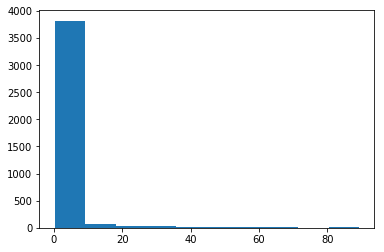

In [14]:
plt.hist(mean_errors)

In [36]:
by_letter_total_error = defaultdict(lambda: 0)
by_letter_counts = defaultdict(lambda: 0)
for letter, img in zip(X_valid_letters, tqdm(X_valid)):
    samples = 10
    for _ in range(samples):
        by_letter_total_error[letter] += get_prediction_error(img)
        by_letter_counts[letter] += 1

mean_error_by_letter = {
    key: by_letter_total_error[key] / by_letter_counts[key]
    for key in by_letter_total_error
}


 19%|█▉        | 763/4002 [00:16<01:18, 41.29it/s]


 38%|███▊      | 1514/4002 [00:32<00:51, 48.17it/s]


 57%|█████▋    | 2265/4002 [00:48<00:38, 45.59it/s]


 75%|███████▌  | 3015/4002 [01:04<00:21, 46.95it/s]


 95%|█████████▍| 3783/4002 [01:21<00:04, 49.15it/s]


100%|█████████▉| 3997/4002 [01:25<00:00, 49.64it/s]

Text(0.5, 0, 'Letter')

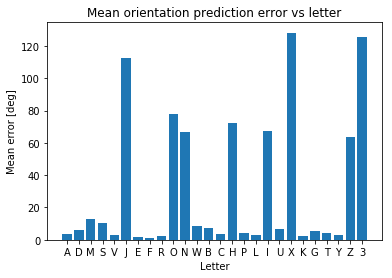


100%|█████████▉| 3997/4002 [01:38<00:00, 49.64it/s]

In [37]:
names = list(mean_error_by_letter.keys())
values = list(mean_error_by_letter.values())

#tick_label does the some work as plt.xticks()
plt.bar(range(len(mean_error_by_letter)),values,tick_label=names)
plt.title("Mean orientation prediction error vs letter")
plt.ylabel("Mean error [deg]")
plt.xlabel("Letter")

Text(0.5, 0, 'Letter')

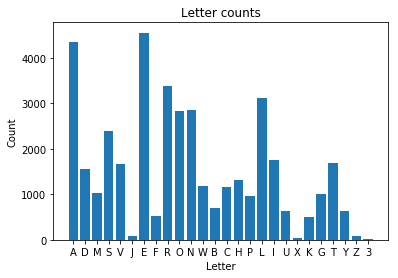

In [38]:
names = list(by_letter_counts.keys())
values = list(by_letter_counts.values())

# tick_label does the some work as plt.xticks()
plt.bar(range(len(by_letter_counts)),values,tick_label=names)
plt.title("Letter counts")
plt.ylabel("Count")
plt.xlabel("Letter")

In [18]:
with open("mean_error_by_letter_mod180.json", 'w') as f:
    json.dump(mean_error_by_letter, f)
    
with open("by_letter_counts.json", 'w') as f:
    json.dump(by_letter_counts, f)

100%|█████████▉| 4000/4002 [01:40<00:00, 45.69it/s]